Importing needed libraries

In [ ]:
# Standard Library
import os

# Data Handling and Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import class_weight, resample

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GRU, LSTM,
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
    Flatten, BatchNormalization
)

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Downloading dataset from Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!ls -l ~/.kaggle/


total 4
-rw------- 1 root root 68 Mar 15 07:55 kaggle.json


In [ ]:
!kaggle datasets download -d sweety18/cicids2017-full-dataset
!unzip cicids2017-full-dataset.zip -d /content/CICIDS2017


Dataset URL: https://www.kaggle.com/datasets/sweety18/cicids2017-full-dataset
License(s): unknown
 97% 166M/172M [00:01<00:00, 165MB/s]
100% 172M/172M [00:01<00:00, 141MB/s]
Archive:  cicids2017-full-dataset.zip
  inflating: /content/CICIDS2017/combine.csv  


In [ ]:
!ls -l /content/CICIDS2017


total 668660
-rw-r--r-- 1 root root 684702235 May 30  2020 combine.csv


Looking through the data

In [ ]:
file_path = "/content/CICIDS2017/combine.csv"
df = pd.read_csv(file_path, low_memory=False)

# Show dataset information
df.info()

# Display first few rows
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214469 entries, 0 to 2214468
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             object 
 1    Flow Duration                float64
 2    Total Fwd Packets            float64
 3    Total Backward Packets       float64
 4   Total Length of Fwd Packets   float64
 5    Total Length of Bwd Packets  float64
 6    Fwd Packet Length Max        float64
 7    Fwd Packet Length Min        float64
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         float64
 11   Bwd Packet Length Min        float64
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


Preprocessing

In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
df["Label"] = df["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)

In [ ]:
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore", inplace=True)

In [ ]:
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1771575, Test samples: 442894


Loading

In [ ]:
file_path = "/content/CICIDS2017/combine.csv"
df = pd.read_csv(file_path, low_memory=False)

df.columns = df.columns.str.strip()

# Convert labels to binary (1 = Attack, 0 = Benign)
df["Label"] = df["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)

# Drop unnecessary columns
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore", inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214469 entries, 0 to 2214468
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             object 
 1   Flow Duration                float64
 2   Total Fwd Packets            float64
 3   Total Backward Packets       float64
 4   Total Length of Fwd Packets  float64
 5   Total Length of Bwd Packets  float64
 6   Fwd Packet Length Max        float64
 7   Fwd Packet Length Min        float64
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        float64
 11  Bwd Packet Length Min        float64
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 float64
 19  

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,55054,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,55055,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,46236,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,54863,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Re-try + some fixes

In [ ]:
input_file = "/content/CICIDS2017/combine.csv"
samples = pd.read_csv(input_file, low_memory=False)

samples.columns = samples.columns.str.strip()
samples["Label"] = samples["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)
samples.replace(['Infinity', np.inf], 0, inplace=True)
samples['Flow Packets/s'] = pd.to_numeric(samples['Flow Packets/s'], errors='coerce').fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'], errors='coerce').fillna(0)

drop_cols = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
samples.drop(columns=drop_cols, errors='ignore', inplace=True)

#The split
train_data, test_data = train_test_split(samples, test_size=0.2, random_state=42, stratify=samples['Label'])

train_output_file = "/content/CICIDS2017/train_data.csv"
test_output_file = "/content/CICIDS2017/test_data.csv"

train_data.to_csv(train_output_file, index=False)
test_data.to_csv(test_output_file, index=False)

print('Training data saved at:', train_output_file)
print('Test data saved at:', test_output_file)

Training data saved at: /content/CICIDS2017/train_data.csv
Test data saved at: /content/CICIDS2017/test_data.csv


In [ ]:
input_file = "/content/CICIDS2017/combine.csv"
output_file = "/content/CICIDS2017/combine_proc.csv"

#data type fix
dtype_spec = {85: str}
df = pd.read_csv(input_file, sep=',', dtype=dtype_spec, low_memory=False)
df.columns = df.columns.str.strip()

Convert Labels to Binary (1 = Attack, 0 = Benign)
df["Label"] = df["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)

# Fix issue
df.replace(['Infinity', np.inf], 0, inplace=True)
df['Flow Packets/s'] = pd.to_numeric(df['Flow Packets/s'], errors='coerce').fillna(0)
df['Flow Bytes/s'] = pd.to_numeric(df['Flow Bytes/s'], errors='coerce').fillna(0)

drop_cols = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

#save
df.to_csv(output_file, index=False)
print('Processed dataset saved at:', output_file)


Processed dataset saved at: /content/CICIDS2017/combine_proc.csv


In [ ]:
def train_test(samples):
    # Import `train_test_split` from `sklearn.model_selection`
    from sklearn.model_selection import train_test_split
    import numpy as np

    # Specify the data
    X=samples.iloc[:,0:(samples.shape[1]-1)]

    # Specify the target labels and flatten the array
    #y= np.ravel(amostras.type)
    y= samples.iloc[:,-1]

    # Split the data up in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test


Normalise the data

In [ ]:
def normalise_data(X_train,X_test):
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test

Reshape

In [ ]:
def format_2d(df):

    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))

In [ ]:
def compile_train(model, X_train, y_train, deep=True, model_name="Model"):
    if deep:
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

        print(f"Training Accuracy Plot for: {model_name}")

        plt.plot(history.history['accuracy'])
        plt.title(f'Model Accuracy: {model_name}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()

        return model
    else:
        model.fit(X_train, y_train)  # No epochs
        print(f" {model_name} trained successfully!")
        return model

In [ ]:
def test(model, X_test, y_test, y_pred, deep=False):
    if deep:
        X_test_3d = format_3d(X_test.copy())
        y_test = np.array(y_test, dtype=np.float32).reshape(-1, 1)

        # Evaluate model
        score = model.evaluate(X_test_3d, y_test, verbose=1)
        print(score)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    avrg = (acc + prec + rec + f1) / 4  # Simple average metric

    return acc, prec, rec, f1, avrg

In [ ]:
def test_normal_atk(y_test,y_pred):
    df = pd.DataFrame()
    df['y_test'] = y_test
    df['y_pred'] = y_pred

    normal = len(df.query('y_test == 0'))
    atk = len(y_test)-normal

    wrong = df.query('y_test != y_pred')

    normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
    atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk

    return normal_detect_rate, atk_detect_rate

Saving the model

In [ ]:
def load_Sklearn(nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'rb') as file:
        model = pickle.load(file)
    print('Model sklearn loaded')
    return model

In [ ]:
def save_Sklearn(model,nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'wb') as file:
        pickle.dump(model,file)
    print('Model sklearn saved')

In [ ]:
def load_model(name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    arq_h5 = 'Models/' + name + '.h5'
    loaded_model.load_weights(arq_h5)

    print('Model loaded')

    return loaded_model

In [ ]:
def save_model(model,name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)

    arq_h5 = 'Models/' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')

Last fix

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()

X = samples.drop(columns=['Label'])  # Features
y = samples['Label']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_full = pd.concat([X_train, y_train], axis=1)

is_benign = X_train_full['Label'] == 0
normal = X_train_full[is_benign]
ddos = X_train_full[~is_benign]

normal_upsampled = resample(normal,
                            replace=True,
                            n_samples=len(ddos),
                            random_state=42)

upsampled = pd.concat([normal_upsampled, ddos])

X_train = upsampled.drop(columns=['Label'])
y_train = upsampled['Label']

input_size = (X_train.shape[1],)

# Cleanup
del X_train_full, normal_upsampled, ddos, upsampled, normal

print("Upsampling complete. Training data is balanced.")

<ipython-input-30-f33d8807fc5c>:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Upsampling complete. Training data is balanced.


In [ ]:
print(GRU_model.__code__.co_varnames)


('input_size', 'model')


GRU

In [ ]:
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [ ]:
def GRU_model(input_size):

    model = Sequential()

    # Fix input shape
    model.add(GRU(32, input_shape=(1, input_size[1]), return_sequences=False))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model


Fixes for GRu

<ipython-input-32-acbd0817723d>:31: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Original X_train shape: (1771574, 78)
After format_3d: (1771574, 1, 78)
GRU Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,093 (43.33 KB)

 Trainable params: 11,093 (43.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 112s 2ms/step - accuracy: 0.7678 - loss: 0.5030 - val_accuracy: 0.7511 - val_loss: 0.5814
Epoch 2/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 109s 2ms/step - accuracy: 0.7699 - loss: 0.5034 - val_accuracy: 0.7073 - val_loss: 0.6047
Epoch 3/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - accuracy: 0.7703 - loss: 0.4992 - val_accuracy: 0.7171 - val_loss: 0.5918
Epoch 4/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step - accuracy: 0.7723 - loss: 0.4982 - val_accuracy: 0.7180 - val_loss: 0.6049
Epoch 5/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step - accuracy: 0.7727 - loss: 0.4996 - val_accuracy: 0.7448 - val_loss: 0.5804
Epoch 6/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step - accuracy: 0.7729 - loss: 0.5003 - val_accuracy: 0.7257 - val_loss: 0.6109
Epoch 7/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 107s 2ms/step - accuracy: 0.7738 - loss: 0.4966 - val_accuracy: 0.7167 - val_loss: 0.5970
Epoch 8/10
44290/44290 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - ac

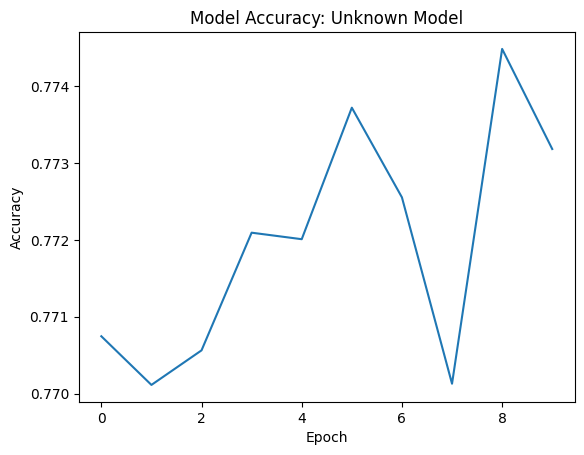

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()

# Split Features (X) and Labels (y)
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)
X_train = X_train.astype(float)

input_size = (1, X_train.shape[1])  # (timesteps, features)

#Debugging Info
print("Original X_train shape:", X_train.shape)  # Should be (samples, features=78)
print("After format_3d:", format_3d(X_train).shape)  # Should be (samples, 1, 78)
print("GRU Expected Input Shape:", (1, X_train.shape[1]))  # Should match (1, 78)


model_gru = GRU_model(input_size)
model_gru = compile_train(model_gru, format_3d(X_train), y_train)

In [ ]:
def GRU_model(input_size):
    model = Sequential()

    # GRU Layer with L2 Regularization
    model.add(GRU(32, input_shape=(1, input_size[1]), return_sequences=False, kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    # Lowered Learning Rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))  # (samples, timesteps=1, features)

<ipython-input-33-942dc5efe341>:35: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1338269
1     433306
Name: count, dtype: int64
Original X_train shape: (1771574, 78)
After format_3d: (1771574, 1, 78)
GRU Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 32)                  │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,093 (43.33 KB)

 Trainable params: 11,093 (43.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.7464 - loss: 0.6029 - val_accuracy: 0.7476 - val_loss: 0.5726
Epoch 2/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7581 - loss: 0.5405 - val_accuracy: 0.7547 - val_loss: 0.5798
Epoch 3/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7577 - loss: 0.5368 - val_accuracy: 0.7550 - val_loss: 0.5689
Epoch 4/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7576 - loss: 0.5357 - val_accuracy: 0.7502 - val_loss: 0.5773
Epoch 5/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7599 - loss: 0.5333 - val_accuracy: 0.7550 - val_loss: 0.5668
Epoch 6/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7574 - loss: 0.5382 - val_accuracy: 0.7528 - val_loss: 0.5753
Epoch 7/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7594 - loss: 0.5361 - val_accuracy: 0.7480 - val_loss: 0.5909
Epoch 8/25
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 

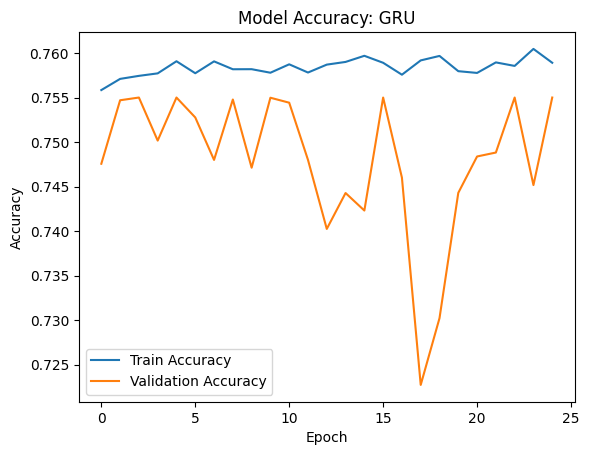

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')

samples.columns = samples.columns.str.strip()

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)
print("Class Distribution in Training Data:\n", y_train.value_counts())


input_size = (1, X_train.shape[1])  # (timesteps, features)


model_gru = GRU_model(input_size)

history = model_gru.fit(
    format_3d(X_train), y_train,
    epochs=25, batch_size=64, validation_split=0.2
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: GRU')
plt.legend()
plt.show()

GRU Model with More Regularisation

In [ ]:
def GRU_model(input_size):

    model = Sequential()

    # GRU Layer with L2 Regularisation
    model.add(GRU(32, input_shape=(1, input_size[1]), return_sequences=False, kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.6))  # Increased Dropout to 0.6
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)  # reduced learning rate to 0.0003
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
# Ensure Correct Reshaping
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))

<ipython-input-34-2e0561e913e3>:33: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1338269
1     433306
Name: count, dtype: int64
Original X_train shape: (1771574, 78)
After format_3d: (1771574, 1, 78)
GRU Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 32)                  │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,093 (43.33 KB)

 Trainable params: 11,093 (43.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7467 - loss: 0.6189 - val_accuracy: 0.7550 - val_loss: 0.5817
Epoch 2/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7601 - loss: 0.5285 - val_accuracy: 0.7413 - val_loss: 0.5697
Epoch 3/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7585 - loss: 0.5365 - val_accuracy: 0.7550 - val_loss: 0.5816
Epoch 4/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.7581 - loss: 0.5359 - val_accuracy: 0.7510 - val_loss: 0.5772
Epoch 5/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.7602 - loss: 0.5321 - val_accuracy: 0.7544 - val_loss: 0.5704
Epoch 6/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7605 - loss: 0.5319 - val_accuracy: 0.7494 - val_loss: 0.5741
Epoch 7/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7592 - loss: 0.5318 - val_accuracy: 0.7550 - val_loss: 0.5727
Epoch 8/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 

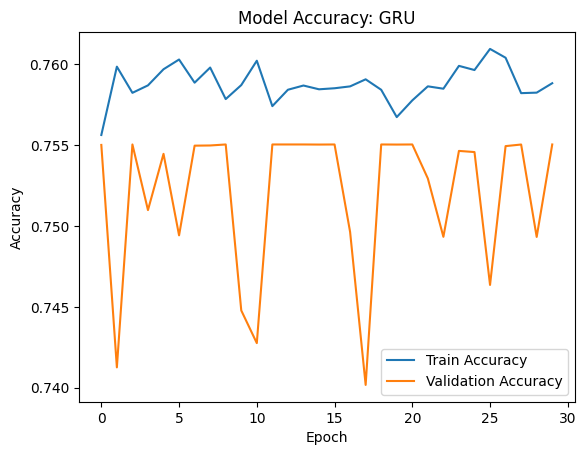

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)
X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = (1, X_train.shape[1])

print("Original X_train shape:", X_train.shape)
print("After format_3d:", format_3d(X_train).shape)
print("GRU Expected Input Shape:", (1, X_train.shape[1]))


model_gru = GRU_model(input_size)
history = model_gru.fit(
    format_3d(X_train), y_train,
    epochs=30, batch_size=64, validation_split=0.2
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: GRU')
plt.legend()
plt.show()

CNN

In [ ]:
#class weights for CNN model
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [ ]:
def CNN_model(input_size):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(input_size[0], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(Dropout(0.6))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)
X_train = X_train.astype(float)


print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = (X_train.shape[1], 1)

print("Original X_train shape:", X_train.shape)
print("After format_3d:", format_3d(X_train).shape)
print("CNN Expected Input Shape:", (X_train.shape[1], 1))


model_cnn = CNN_model(input_size)
model_cnn.fit(
    format_cnn(X_train), y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: CNN')
plt.legend()
plt.show()

LSTM

In [ ]:
def LSTM_model(input_size):
    model = Sequential()

    model.add(LSTM(32, input_shape=(1, input_size[1]), return_sequences=False, kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.6))
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))

<ipython-input-41-3004942c71bb>:32: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1338269
1     433306
Name: count, dtype: int64
Original X_train shape: (1771574, 78)
After format_3d: (1771574, 1, 78)
LSTM Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │          14,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,549 (56.83 KB)

 Trainable params: 14,549 (56.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7509 - loss: 0.6223 - val_accuracy: 0.7550 - val_loss: 0.5609
Epoch 2/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.7553 - loss: 0.5495 - val_accuracy: 0.7550 - val_loss: 0.5676
Epoch 3/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7555 - loss: 0.5412 - val_accuracy: 0.7550 - val_loss: 0.5670
Epoch 4/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.7547 - loss: 0.5450 - val_accuracy: 0.7550 - val_loss: 0.5709
Epoch 5/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7569 - loss: 0.5397 - val_accuracy: 0.7548 - val_loss: 0.5695
Epoch 6/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7570 - loss: 0.5443 - val_accuracy: 0.7550 - val_loss: 0.5666
Epoch 7/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7560 - loss: 0.5427 - val_accuracy: 0.7550 - val_loss: 0.5828
Epoch 8/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 

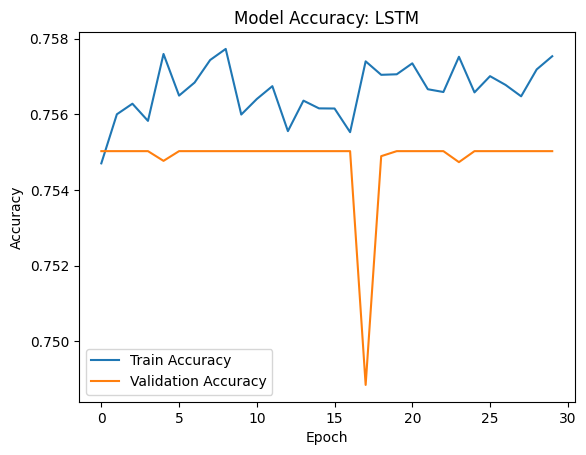

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)
X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = (1, X_train.shape[1])

print("Original X_train shape:", X_train.shape)
print("After format_3d:", format_3d(X_train).shape)
print("LSTM Expected Input Shape:", (1, X_train.shape[1]))

model_lstm = LSTM_model(input_size)
history = model_lstm.fit(
    format_3d(X_train), y_train,
    epochs=30, batch_size=64, validation_split=0.2
)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: LSTM')
plt.legend()
plt.show()

DNN

In [ ]:
def DNN_model(input_size):
    model = Sequential()

    # Input Layer
    model.add(Dense(128, activation='relu', input_shape=(input_size,)))
    model.add(Dropout(0.5))

    # Hidden Layers
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

<ipython-input-42-ae22a0641710>:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1338269
1     433306
Name: count, dtype: int64
Original X_train shape: (1771574, 78)
DNN Expected Input Shape: 78


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 128)                 │          10,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,481 (80.00 KB)

 Trainable params: 20,481 (80.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.6616 - loss: 113710.9922 - val_accuracy: 0.7550 - val_loss: 1.7069
Epoch 2/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.7543 - loss: 3.8464 - val_accuracy: 0.7550 - val_loss: 0.7028
Epoch 3/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7552 - loss: 7.8344 - val_accuracy: 0.7550 - val_loss: 0.7212
Epoch 4/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.7552 - loss: 0.6141 - val_accuracy: 0.7550 - val_loss: 0.5717
Epoch 5/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.7552 - loss: 0.5678 - val_accuracy: 0.7550 - val_loss: 0.7140
Epoch 6/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7558 - loss: 0.6119 - val_accuracy: 0.7550 - val_loss: 0.6274
Epoch 7/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7561 - loss: 0.5600 - val_accuracy: 0.7550 - val_loss: 0.5796
Epoch 8/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accur

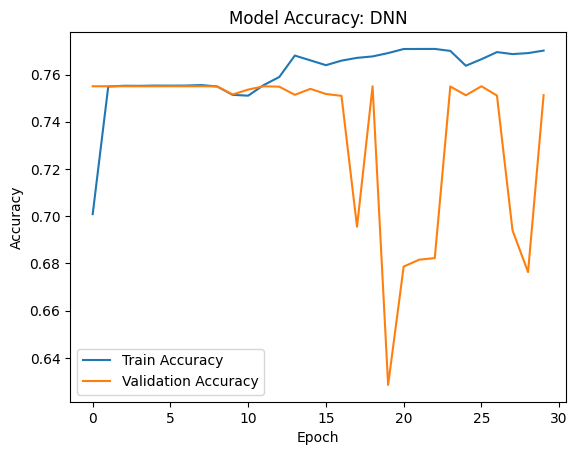

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = X_train.shape[1]

print("Original X_train shape:", X_train.shape)
print("DNN Expected Input Shape:", input_size)

model_dnn = DNN_model(input_size)
history = model_dnn.fit(
    X_train, y_train,
    epochs=30, batch_size=64, validation_split=0.2
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: DNN')
plt.legend()
plt.show()

LR

In [ ]:
def LR():
    return LogisticRegression()

<ipython-input-43-088768fcca48>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


X_train shape: (1771574, 78)
y_train shape: (1771574,)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression Accuracy: 0.9168

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    334568
           1       0.76      0.97      0.85    108326

    accuracy                           0.92    442894
   macro avg       0.87      0.94      0.90    442894
weighted avg       0.93      0.92      0.92    442894



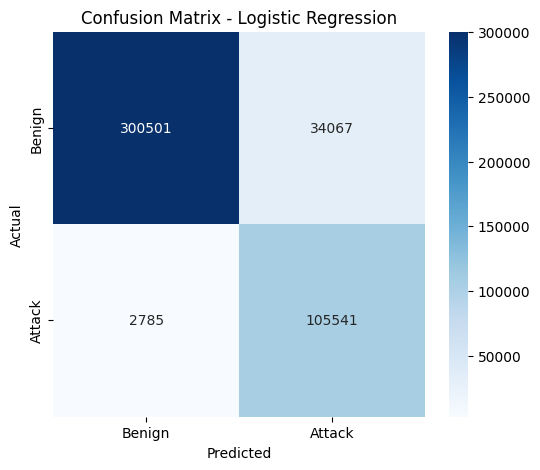

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
samples.dropna(inplace=True)

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train = X_train.astype(float)
X_test = X_test.astype(float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

model_lr = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)
model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

GD

In [ ]:
def GD():
    return SGDClassifier()

<ipython-input-44-898fe100a2dd>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Gradient Descent (SGD) Accuracy: 0.9136

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    334568
           1       0.75      0.97      0.85    108326

    accuracy                           0.91    442894
   macro avg       0.87      0.93      0.89    442894
weighted avg       0.93      0.91      0.92    442894



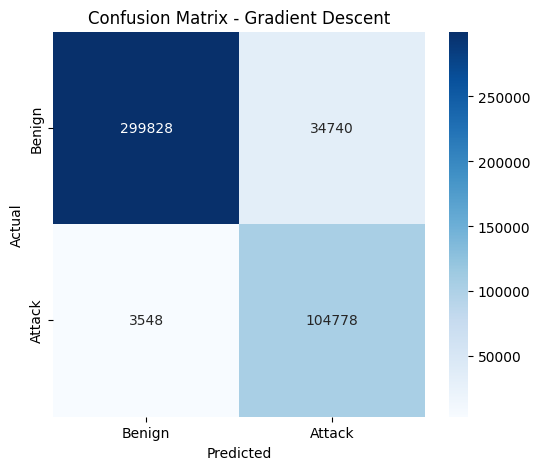

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
samples.dropna(inplace=True)

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train = X_train.astype(float)
X_test = X_test.astype(float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_gd = SGDClassifier(loss='log_loss',
                         penalty='l2',
                         learning_rate='optimal',
                         class_weight='balanced',
                         random_state=42)

model_gd.fit(X_train_scaled, y_train)

y_pred = model_gd.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Descent (SGD) Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Descent")
plt.show()

SGD

<ipython-input-45-5fa8bc8a5846>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


SVM (SGD) Accuracy: 0.9150

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    334568
           1       0.75      0.97      0.85    108326

    accuracy                           0.92    442894
   macro avg       0.87      0.94      0.89    442894
weighted avg       0.93      0.92      0.92    442894



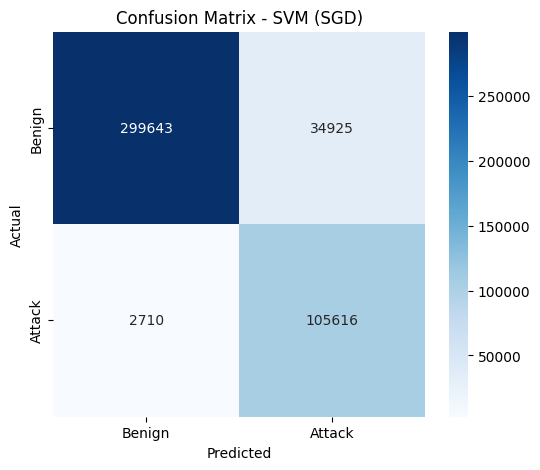

In [ ]:
samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
samples.dropna(inplace=True)

X = samples.drop(columns=['Label'])
y = samples['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train = X_train.astype(float)
X_test = X_test.astype(float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_svm = SGDClassifier(loss='hinge',
                          penalty='l2',
                          learning_rate='optimal',
                          class_weight='balanced',
                          random_state=42)

model_svm.fit(X_train_scaled, y_train)
y_pred = model_svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM (SGD) Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (SGD)")
plt.show()

GB

<ipython-input-49-70a0e8029752>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


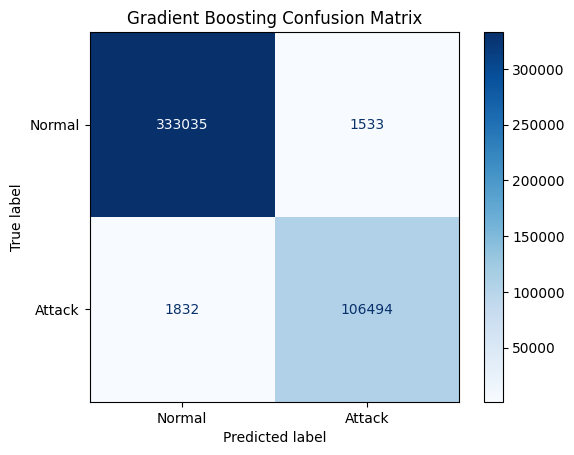

               Model  Accuracy  Precision    Recall  F1-Score  \
0  Gradient Boosting  0.992402   0.985809  0.983088  0.984447   

   Normal Detection Rate  Attack Detection Rate  
0               0.995418               0.983088  


In [ ]:
if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_gb}).query('y_test != y_pred')

normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

# Append to results
results = pd.concat([results, new_row], ignore_index=True)


cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


print(results.tail())


In [ ]:
print("Train Class Distribution:\n", y_train.value_counts())
print("Test Class Distribution:\n", y_test.value_counts())


Train Class Distribution:
 Label
0    1338269
1     433305
Name: count, dtype: int64
Test Class Distribution:
 Label
0    334568
1    108326
Name: count, dtype: int64


GRU attempt 2

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = model_gru.fit(
    format_3d(X_train), y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights  #new
)


Epoch 1/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.7012 - loss: 0.5792 - val_accuracy: 0.8434 - val_loss: 0.4972
Epoch 2/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.7095 - loss: 0.5729 - val_accuracy: 0.8495 - val_loss: 0.4803
Epoch 3/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.6826 - loss: 0.5452 - val_accuracy: 0.6824 - val_loss: 0.4818
Epoch 4/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.7103 - loss: 0.5339 - val_accuracy: 0.8191 - val_loss: 0.3861
Epoch 5/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.7140 - loss: 0.5070 - val_accuracy: 0.7362 - val_loss: 0.4443
Epoch 6/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.7217 - loss: 0.5099 - val_accuracy: 0.8152 - val_loss: 0.4515
Epoch 7/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7026 - loss: 0.5143 - val_accuracy: 0.7900 - val_loss: 0.4204
Epoch 8/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 

### CNN

In [ ]:
def format_cnn(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))  # (samples, features, 1)


### LSTM

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Train LSTM model with class weighting
history = model_lstm.fit(
    format_3d(X_train), y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights
)


Epoch 1/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.6503 - loss: 0.5959 - val_accuracy: 0.7889 - val_loss: 0.5014
Epoch 2/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.6527 - loss: 0.5739 - val_accuracy: 0.7091 - val_loss: 0.4947
Epoch 3/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.6761 - loss: 0.5471 - val_accuracy: 0.7732 - val_loss: 0.4448
Epoch 4/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.6710 - loss: 0.5420 - val_accuracy: 0.7269 - val_loss: 0.4398
Epoch 5/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.6669 - loss: 0.5532 - val_accuracy: 0.6804 - val_loss: 0.4988
Epoch 6/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.6778 - loss: 0.5427 - val_accuracy: 0.6867 - val_loss: 0.4870
Epoch 7/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.6727 - loss: 0.5377 - val_accuracy: 0.7105 - val_loss: 0.4902
Epoch 8/30
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 

In [ ]:
def test_normal_atk(y_test, y_pred):
    y_test = y_test.ravel()  # flatten to 1D
    y_pred = y_pred.ravel()

    test_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    normal = (test_df['y_test'] == 0).sum()
    atk = (test_df['y_test'] == 1).sum()

    wrong = test_df[test_df['y_test'] != test_df['y_pred']]
    wrong_counts = wrong.groupby('y_test').size()

    wrong_norm = wrong_counts.get(0, 0)
    wrong_atk = wrong_counts.get(1, 0)

    normal_detect_rate = (normal - wrong_norm) / normal if normal else 0
    atk_detect_rate = (atk - wrong_atk) / atk if atk else 0

    return normal_detect_rate, atk_detect_rate


Gru and lstm

🔍 Evaluating GRU...
13841/13841 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


<ipython-input-53-0e802b84da54>:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()  # flatten to 1D


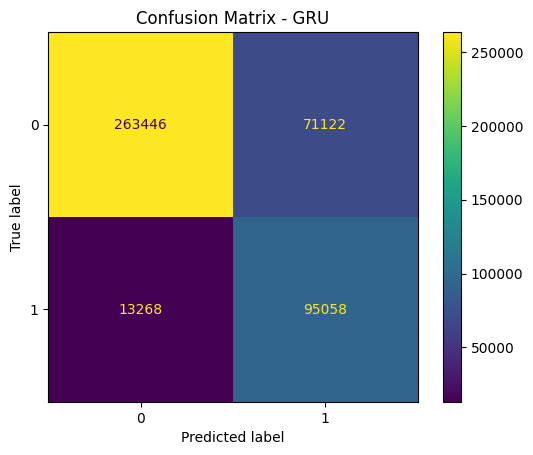

🔍 Evaluating LSTM...
13841/13841 ━━━━━━━━━━━━━━━━━━━━ 14s 994us/step


<ipython-input-53-0e802b84da54>:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()  # flatten to 1D


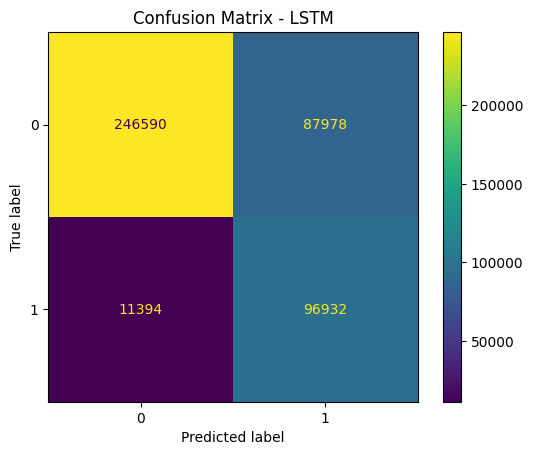

,Method,Accuracy,Precision,Recall,F1_Score,Average,Normal_Detect_Rate,Atk_Detect_Rate
0,GRU,0.809458,0.572018,0.877518,0.692575,0.737892,0.787421,0.877518
1,LSTM,0.775630,0.524212,0.894817,0.661119,0.713945,0.737040,0.894817


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [('GRU', model_gru), ('LSTM', model_lstm)]
results_list = []

for name, model in models:
    print(f"🔍 Evaluating {name}...")

    X_input = format_3d(X_test)
    y_pred = model.predict(X_input).round()

    acc, prec, rec, f1, avg = test(model, X_input, y_test, y_pred)
    norm, atk = test_normal_atk(y_test, y_pred)

    results_list.append({
        'Method': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'Average': avg,
        'Normal_Detect_Rate': norm,
        'Atk_Detect_Rate': atk
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Output the results
results_df = pd.DataFrame(results_list)
display(results_df)


In [ ]:
def format_3d(df):
    X = np.array(df)
    return X.reshape(X.shape[0], X.shape[1], 1)


In [ ]:
# Correct CNN Prediction:
X_test_cnn = format_3d(X_test)
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)


13841/13841 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step


CNN 2

13841/13841 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step


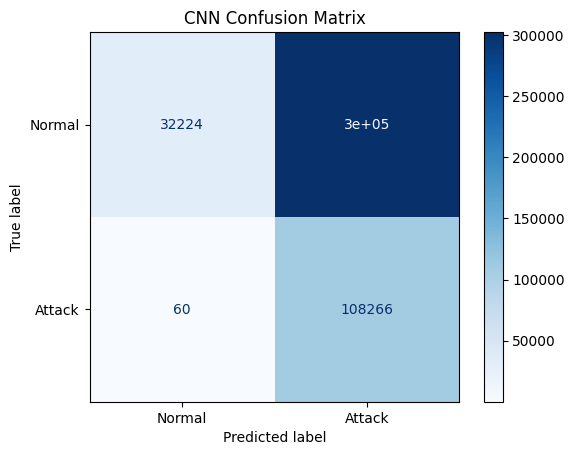

               Model  Accuracy  Precision    Recall  F1-Score  \
0  Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
1                CNN  0.317209   0.263671  0.999446  0.417261   

   Normal Detection Rate  Attack Detection Rate  
0               0.995418               0.983088  
1               0.096315               0.999446  


In [ ]:
# CNN Predictions & Evaluation
X_test_cnn = format_3d(X_test)
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

#metrics
accuracy = accuracy_score(y_test, y_pred_cnn)
precision = precision_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_cnn.flatten()}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'CNN',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)


cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()


print(results.tail())

CNN with threshhold

13841/13841 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step


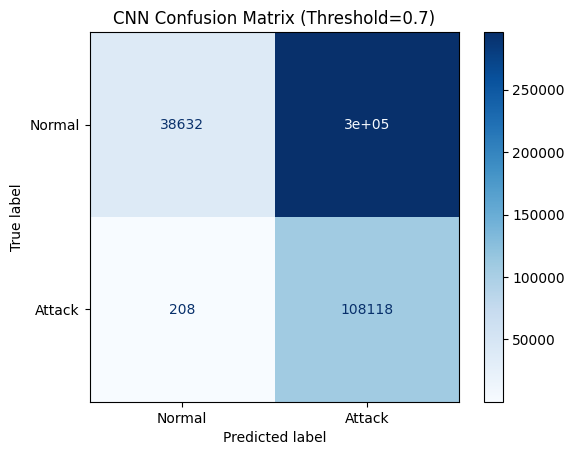

                 Model  Accuracy  Precision    Recall  F1-Score  \
0    Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
1                  CNN  0.317209   0.263671  0.999446  0.417261   
2  CNN (Threshold=0.7)  0.331343   0.267583  0.998080  0.422023   

   Normal Detection Rate  Attack Detection Rate  
0               0.995418               0.983088  
1               0.096315               0.999446  
2               0.115468               0.998080  


In [ ]:
X_test_cnn = format_3d(X_test)
y_pred_prob_cnn = model_cnn.predict(X_test_cnn)

# Adjusting threshold for better balance (trying 0.7)
threshold = 0.7
y_pred_cnn = (y_pred_prob_cnn > threshold).astype(int)


accuracy = accuracy_score(y_test, y_pred_cnn)
precision = precision_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

# Error analysis
wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_cnn.flatten()}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': f'CNN (Threshold={threshold})',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"CNN Confusion Matrix (Threshold={threshold})")
plt.show()

print(results.tail())

In [ ]:
class_weights = {0: 5, 1: 1}  # Heavier penalty on misclassifying normal as attacks

model_cnn.fit(
    format_3d(X_train), y_train, epochs=10, batch_size=64,
    validation_split=0.2, class_weight=class_weights
)


Epoch 1/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 304s 14ms/step - accuracy: 0.9558 - loss: 0.1964 - val_accuracy: 0.3671 - val_loss: 6.3067
Epoch 2/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 303s 14ms/step - accuracy: 0.9596 - loss: 0.1498 - val_accuracy: 0.4079 - val_loss: 0.7809
Epoch 3/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 386s 17ms/step - accuracy: 0.9604 - loss: 0.1447 - val_accuracy: 0.4237 - val_loss: 0.9848
Epoch 4/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 335s 15ms/step - accuracy: 0.9609 - loss: 0.1422 - val_accuracy: 0.3984 - val_loss: 0.9205
Epoch 5/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 334s 15ms/step - accuracy: 0.9615 - loss: 0.1406 - val_accuracy: 0.3638 - val_loss: 1.4611
Epoch 6/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 328s 15ms/step - accuracy: 0.9637 - loss: 0.1380 - val_accuracy: 0.5245 - val_loss: 0.7054
Epoch 7/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 330s 15ms/step - accuracy: 0.9784 - loss: 0.1136 - val_accuracy: 0.3551 - val_loss: 1.3195
Epoch 8/10
22145/22145 ━━━━━━━━━━━━━━━━━━━━ 334s 15ms/s

In [ ]:
threshold = 0.7
y_pred_cnn = (model_cnn.predict(format_3d(X_test)) > threshold).astype(int)

13841/13841 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step


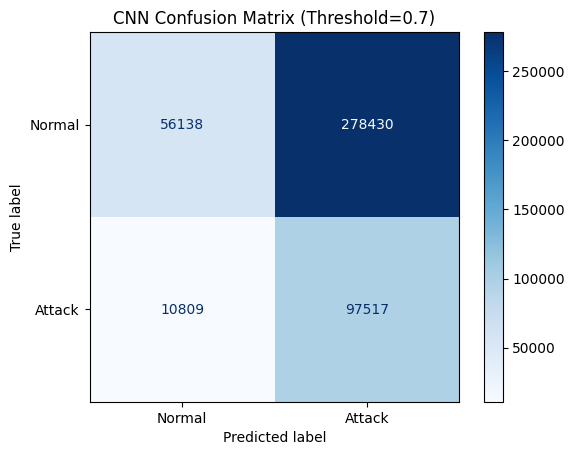

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("CNN Confusion Matrix (Threshold=0.7)")
plt.show()

DNN again

13841/13841 ━━━━━━━━━━━━━━━━━━━━ 11s 780us/step


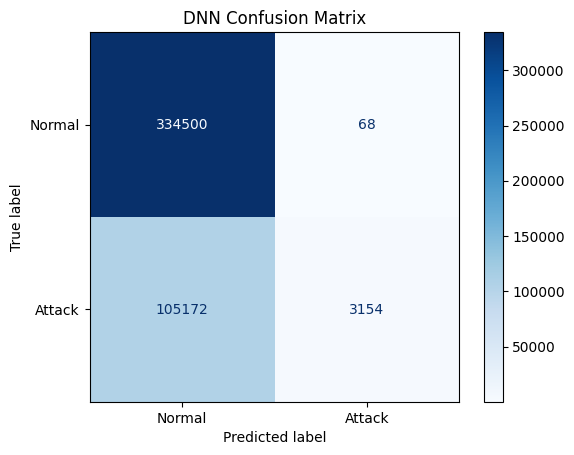

              precision    recall  f1-score   support

      Normal       0.76      1.00      0.86    334568
      Attack       0.98      0.03      0.06    108326

    accuracy                           0.76    442894
   macro avg       0.87      0.51      0.46    442894
weighted avg       0.81      0.76      0.67    442894

                 Model  Accuracy  Precision    Recall  F1-Score  \
0    Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
1                  CNN  0.317209   0.263671  0.999446  0.417261   
2  CNN (Threshold=0.7)  0.331343   0.267583  0.998080  0.422023   
3                  DNN  0.762381   0.978895  0.029116  0.056550   

   Normal Detection Rate  Attack Detection Rate  
0               0.995418               0.983088  
1               0.096315               0.999446  
2               0.115468               0.998080  
3               0.999797               0.029116  


In [ ]:
y_pred_dnn = model_dnn.predict(X_test).round().astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_dnn)
precision = precision_score(y_test, y_pred_dnn)
recall = recall_score(y_test, y_pred_dnn)
f1 = f1_score(y_test, y_pred_dnn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_dnn}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'DNN',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)
cm = confusion_matrix(y_test, y_pred_dnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("DNN Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_dnn, target_names=['Normal', 'Attack']))
print(results.tail())

In [ ]:
threshold = 0.3
y_pred_dnn = (model_dnn.predict(X_test) > threshold).astype(int).flatten()


13841/13841 ━━━━━━━━━━━━━━━━━━━━ 10s 737us/step


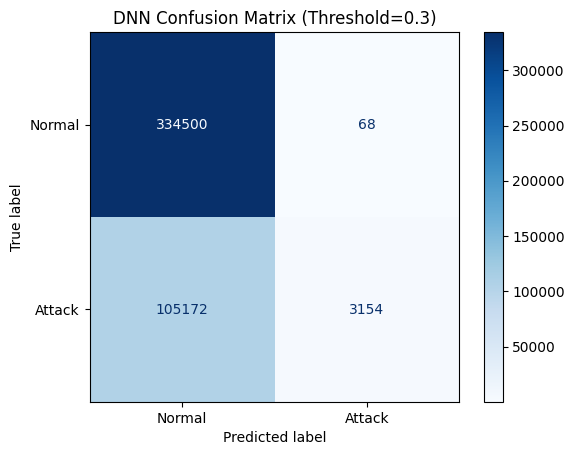

              precision    recall  f1-score   support

      Normal       0.97      0.91      0.94    334568
      Attack       0.76      0.92      0.83    108326

    accuracy                           0.91    442894
   macro avg       0.87      0.91      0.89    442894
weighted avg       0.92      0.91      0.91    442894



In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"DNN Confusion Matrix (Threshold={threshold})")
plt.show()

print(classification_report(y_test, y_pred_dnn, target_names=['Normal', 'Attack']))


13841/13841 ━━━━━━━━━━━━━━━━━━━━ 12s 834us/step


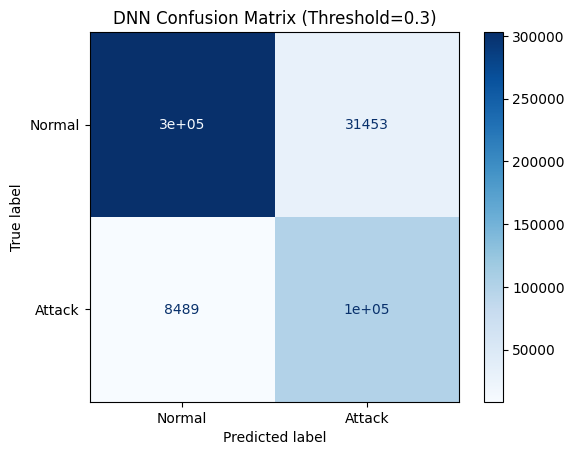

              precision    recall  f1-score   support

      Normal       0.97      0.91      0.94    334568
      Attack       0.76      0.92      0.83    108326

    accuracy                           0.91    442894
   macro avg       0.87      0.91      0.89    442894
weighted avg       0.92      0.91      0.91    442894

                 Model  Accuracy  Precision    Recall  F1-Score  \
1                  CNN  0.317209   0.263671  0.999446  0.417261   
2  CNN (Threshold=0.7)  0.331343   0.267583  0.998080  0.422023   
3                  DNN  0.762381   0.978895  0.029116  0.056550   
4  SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
5  DNN (Threshold=0.3)  0.909816   0.760431  0.921635  0.833308   

   Normal Detection Rate  Attack Detection Rate  
1               0.096315               0.999446  
2               0.115468               0.998080  
3               0.999797               0.029116  
4               0.905989               0.921635  
5               0.90

In [ ]:
threshold = 0.3
y_pred_dnn = (model_dnn.predict(X_test) > threshold).astype(int).flatten()

# Metrics
accuracy = accuracy_score(y_test, y_pred_dnn)
precision = precision_score(y_test, y_pred_dnn)
recall = recall_score(y_test, y_pred_dnn)
f1 = f1_score(y_test, y_pred_dnn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_dnn}).query('y_test != y_pred')

normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

# Store Results
new_row = pd.DataFrame([{
    'Model': f'DNN (Threshold={threshold})',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_dnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"DNN Confusion Matrix (Threshold={threshold})")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dnn, target_names=['Normal', 'Attack']))
print(results.tail())

LR

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


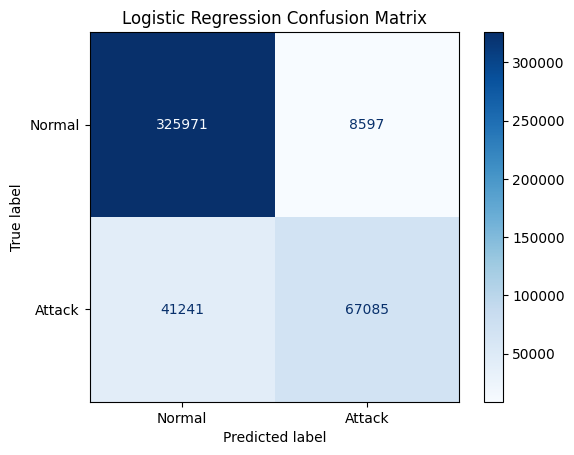

              precision    recall  f1-score   support

      Normal       0.89      0.97      0.93    334568
      Attack       0.89      0.62      0.73    108326

    accuracy                           0.89    442894
   macro avg       0.89      0.80      0.83    442894
weighted avg       0.89      0.89      0.88    442894

                 Model  Accuracy  Precision    Recall  F1-Score  \
3                  DNN  0.762381   0.978895  0.029116  0.056550   
4  SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
5  DNN (Threshold=0.3)  0.909816   0.760431  0.921635  0.833308   
6  Logistic Regression  0.887472   0.886406  0.619288  0.729153   
7  Logistic Regression  0.887472   0.886406  0.619288  0.729153   

   Normal Detection Rate  Attack Detection Rate  
3               0.999797               0.029116  
4               0.905989               0.921635  
5               0.905989               0.921635  
6               0.974304               0.619288  
7               0.97

In [ ]:
if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_lr}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'Logistic Regression',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Attack']))
print(results.tail())

In [ ]:
threshold = 0.4
y_pred_lr_prob = model_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_pred_lr_prob > threshold).astype(int)


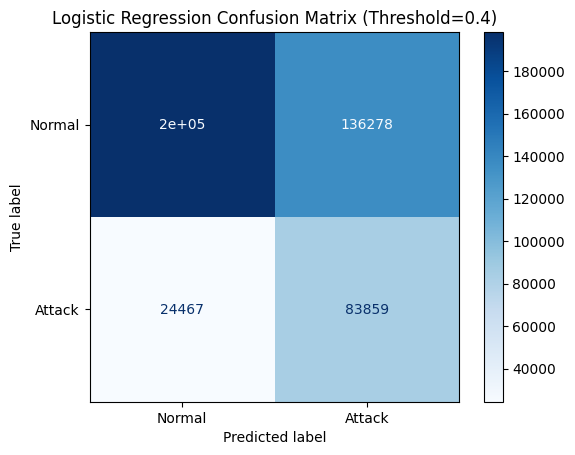

              precision    recall  f1-score   support

      Normal       0.89      0.59      0.71    334568
      Attack       0.38      0.77      0.51    108326

    accuracy                           0.64    442894
   macro avg       0.64      0.68      0.61    442894
weighted avg       0.77      0.64      0.66    442894



In [ ]:
cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"Logistic Regression Confusion Matrix (Threshold={threshold})")
plt.show()

print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Attack']))

SDG

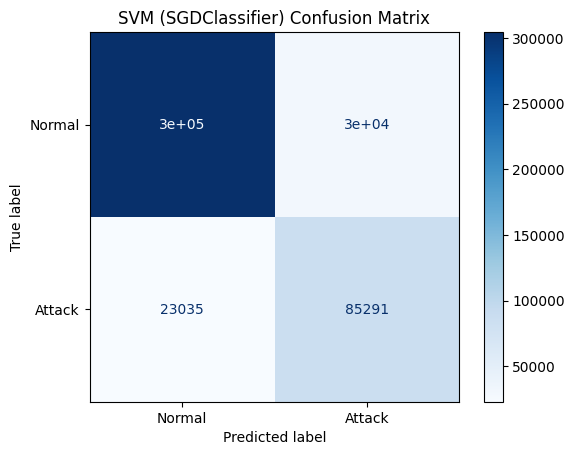

              precision    recall  f1-score   support

      Normal       0.93      0.91      0.92    334568
      Attack       0.74      0.79      0.76    108326

    accuracy                           0.88    442894
   macro avg       0.83      0.85      0.84    442894
weighted avg       0.88      0.88      0.88    442894

                 Model  Accuracy  Precision    Recall  F1-Score  \
4  SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
5  DNN (Threshold=0.3)  0.909816   0.760431  0.921635  0.833308   
6  Logistic Regression  0.887472   0.886406  0.619288  0.729153   
7  Logistic Regression  0.887472   0.886406  0.619288  0.729153   
8  SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   

   Normal Detection Rate  Attack Detection Rate  
4               0.905989               0.921635  
5               0.905989               0.921635  
6               0.974304               0.619288  
7               0.974304               0.619288  
8               0.91

In [ ]:
if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_svm = SGDClassifier(loss='hinge', random_state=42)
model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_svm}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'SVM (SGDClassifier)',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("SVM (SGDClassifier) Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Attack']))
print(results.tail())


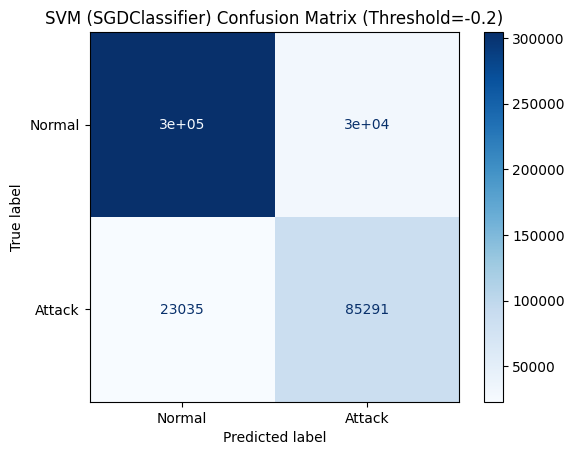

              precision    recall  f1-score   support

      Normal       0.93      0.91      0.92    334568
      Attack       0.74      0.79      0.76    108326

    accuracy                           0.88    442894
   macro avg       0.83      0.85      0.84    442894
weighted avg       0.88      0.88      0.88    442894



In [ ]:
threshold = -0.2
y_pred_svm_decision = model_svm.decision_function(X_test)
y_pred_svm = (y_pred_svm_decision > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"SVM (SGDClassifier) Confusion Matrix (Threshold={threshold})")
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Attack']))

GB

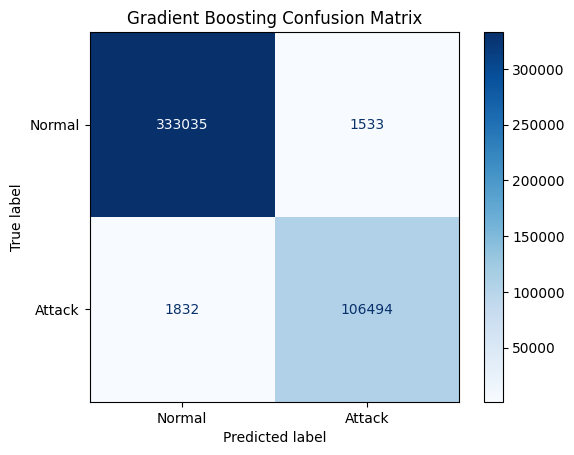

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    334568
      Attack       0.99      0.98      0.98    108326

    accuracy                           0.99    442894
   macro avg       0.99      0.99      0.99    442894
weighted avg       0.99      0.99      0.99    442894

                 Model  Accuracy  Precision    Recall  F1-Score  \
5  DNN (Threshold=0.3)  0.909816   0.760431  0.921635  0.833308   
6  Logistic Regression  0.887472   0.886406  0.619288  0.729153   
7  Logistic Regression  0.887472   0.886406  0.619288  0.729153   
8  SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
9    Gradient Boosting  0.992402   0.985809  0.983088  0.984447   

   Normal Detection Rate  Attack Detection Rate  
5               0.905989               0.921635  
6               0.974304               0.619288  
7               0.974304               0.619288  
8               0.910398               0.787355  
9               0.99

In [ ]:
# Ensure 'results' DataFrame exists
if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])
model_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_gb}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_gb, target_names=['Normal', 'Attack']))
print(results.tail())

KNN

In [ ]:
def kNN():
    return KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

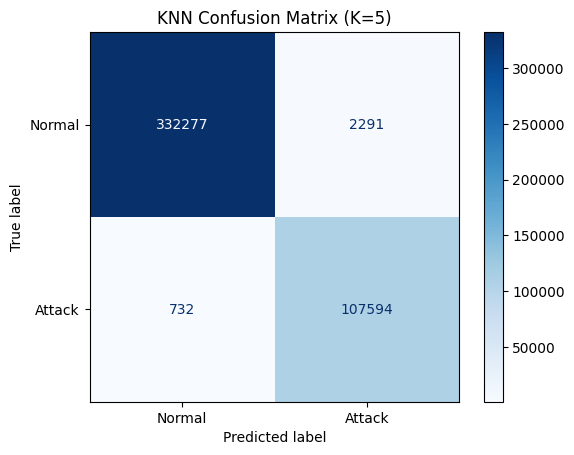

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    334568
      Attack       0.98      0.99      0.99    108326

    accuracy                           0.99    442894
   macro avg       0.99      0.99      0.99    442894
weighted avg       0.99      0.99      0.99    442894

                        Model  Accuracy  Precision    Recall  F1-Score  \
6         Logistic Regression  0.887472   0.886406  0.619288  0.729153   
7         Logistic Regression  0.887472   0.886406  0.619288  0.729153   
8         SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
9           Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
10  K-Nearest Neighbors (K=5)  0.993174   0.979151  0.993243  0.986146   

    Normal Detection Rate  Attack Detection Rate  
6                0.974304               0.619288  
7                0.974304               0.619288  
8                0.910398               0.787355  
9                0.99541

In [ ]:
if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_knn}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'K-Nearest Neighbors (K=5)',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("KNN Confusion Matrix (K=5)")
plt.show()

print(classification_report(y_test, y_pred_knn, target_names=['Normal', 'Attack']))
print(results.tail())

Gru Again

13841/13841 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


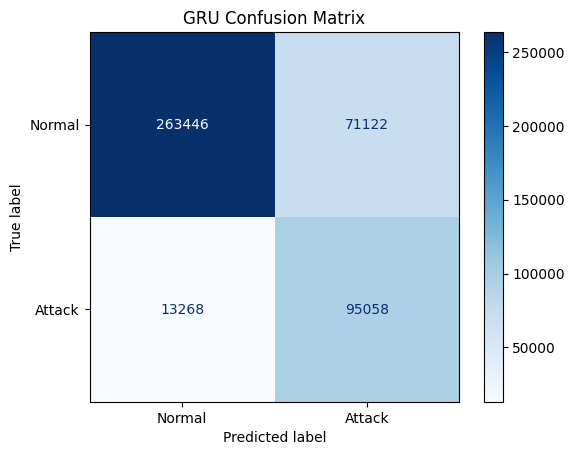

              precision    recall  f1-score   support

      Normal       0.95      0.79      0.86    334568
      Attack       0.57      0.88      0.69    108326

    accuracy                           0.81    442894
   macro avg       0.76      0.83      0.78    442894
weighted avg       0.86      0.81      0.82    442894

                        Model  Accuracy  Precision    Recall  F1-Score  \
7         Logistic Regression  0.887472   0.886406  0.619288  0.729153   
8         SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
9           Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
10  K-Nearest Neighbors (K=5)  0.993174   0.979151  0.993243  0.986146   
11                        GRU  0.809458   0.572018  0.877518  0.692575   

    Normal Detection Rate  Attack Detection Rate  
7                0.974304               0.619288  
8                0.910398               0.787355  
9                0.995418               0.983088  
10               0.99315

In [ ]:
def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))  # Fixes the input shape issue


threshold = 0.5
y_pred_gru = (model_gru.predict(format_3d(X_test)) > threshold).astype(int).flatten()


accuracy = accuracy_score(y_test, y_pred_gru)
precision = precision_score(y_test, y_pred_gru)
recall = recall_score(y_test, y_pred_gru)
f1 = f1_score(y_test, y_pred_gru)


wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_gru}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'GRU',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_gru)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("GRU Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_gru, target_names=['Normal', 'Attack']))
print(results.tail())

Lstm

13841/13841 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


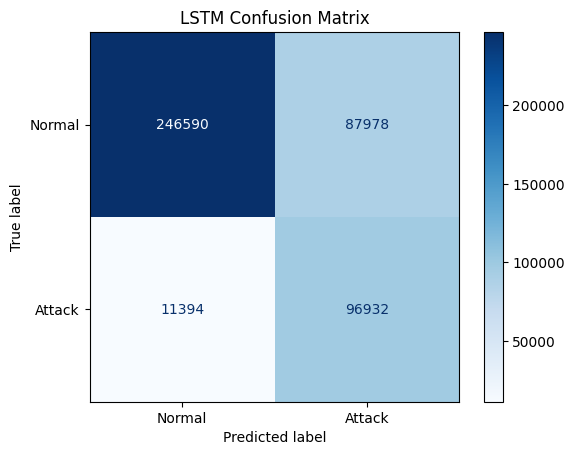

              precision    recall  f1-score   support

      Normal       0.96      0.74      0.83    334568
      Attack       0.52      0.89      0.66    108326

    accuracy                           0.78    442894
   macro avg       0.74      0.82      0.75    442894
weighted avg       0.85      0.78      0.79    442894

                        Model  Accuracy  Precision    Recall  F1-Score  \
8         SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
9           Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
10  K-Nearest Neighbors (K=5)  0.993174   0.979151  0.993243  0.986146   
11                        GRU  0.809458   0.572018  0.877518  0.692575   
12                       LSTM  0.775630   0.524212  0.894817  0.661119   

    Normal Detection Rate  Attack Detection Rate  
8                0.910398               0.787355  
9                0.995418               0.983088  
10               0.993152               0.993243  
11               0.78742

In [ ]:
threshold = 0.5
y_pred_lstm = (model_lstm.predict(format_3d(X_test)) > threshold).astype(int).flatten()


accuracy = accuracy_score(y_test, y_pred_lstm)
precision = precision_score(y_test, y_pred_lstm)
recall = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_lstm}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'LSTM',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_lstm, target_names=['Normal', 'Attack']))
print(results.tail())

In [ ]:
results


,Model,Accuracy,Precision,Recall,F1-Score,Normal Detection Rate,Attack Detection Rate
0,Gradient Boosting,0.992402,0.985809,0.983088,0.984447,0.995418,0.983088
1,CNN,0.317209,0.263671,0.999446,0.417261,0.096315,0.999446
2,CNN (Threshold=0.7),0.331343,0.267583,0.998080,0.422023,0.115468,0.998080
3,DNN,0.762381,0.978895,0.029116,0.056550,0.999797,0.029116
4,SVM (SGDClassifier),0.880303,0.739930,0.787355,0.762906,0.905989,0.921635
5,DNN (Threshold=0.3),0.909816,0.760431,0.921635,0.833308,0.905989,0.921635
6,Logistic Regression,0.887472,0.886406,0.619288,0.729153,0.974304,0.619288
7,Logistic Regression,0.887472,0.886406,0.619288,0.729153,0.974304,0.619288
8,SVM (SGDClassifier),0.880303,0.739930,0.787355,0.762906,0.910398,0.787355
9,Gradient Boosting,0.992402,0.985809,0.983088,0.984447,0.995418,0.983088


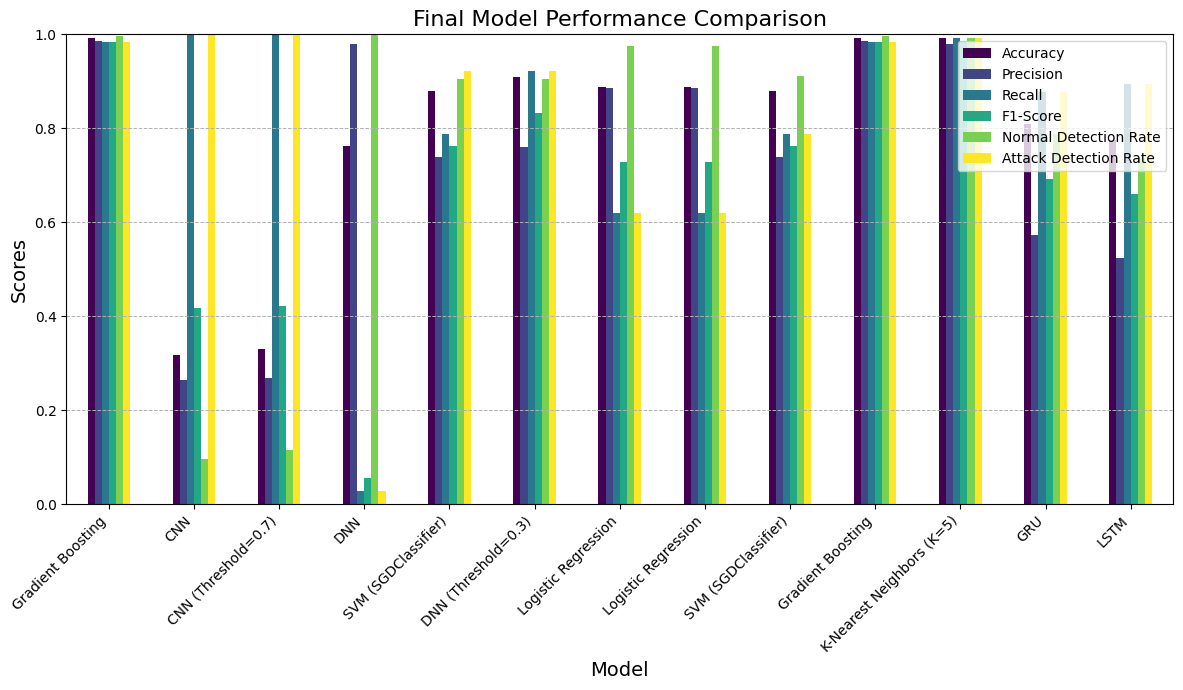

                        Model  Accuracy  Precision    Recall  F1-Score  \
0           Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
1                         CNN  0.317209   0.263671  0.999446  0.417261   
2         CNN (Threshold=0.7)  0.331343   0.267583  0.998080  0.422023   
3                         DNN  0.762381   0.978895  0.029116  0.056550   
4         SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
5         DNN (Threshold=0.3)  0.909816   0.760431  0.921635  0.833308   
6         Logistic Regression  0.887472   0.886406  0.619288  0.729153   
7         Logistic Regression  0.887472   0.886406  0.619288  0.729153   
8         SVM (SGDClassifier)  0.880303   0.739930  0.787355  0.762906   
9           Gradient Boosting  0.992402   0.985809  0.983088  0.984447   
10  K-Nearest Neighbors (K=5)  0.993174   0.979151  0.993243  0.986146   
11                        GRU  0.809458   0.572018  0.877518  0.692575   
12                       LSTM  0.77563

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Confirm all models are included
expected_models = ['GRU', 'LSTM', 'CNN', 'DNN', 'SVM (SGDClassifier)',
                   'Logistic Regression', 'Gradient Boosting', 'K-Nearest Neighbors (K=5)']

# Check explicitly for missing models
missing_models = set(expected_models) - set(results['Model'])
if missing_models:
    print(f"Warning: Missing models from results: {missing_models}")
else:
    # Clearly define key metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score',
               'Normal Detection Rate', 'Attack Detection Rate']

    # Plot results explicitly
    results_plot = results.set_index('Model')[metrics]
    results_plot.plot(kind='bar', figsize=(12, 7), colormap='viridis')

    plt.title('Final Model Performance Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.tight_layout()

    plt.show()

# Display results DataFrame explicitly
print(results)